In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np 
import pandas as pd
import xml.etree.ElementTree as ET
from PIL import Image
import cv2
import os
import xml.dom.minidom

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input, Concatenate, UpSampling2D
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory


In [2]:
height , width = 1024 , 1024 #size to which input image needs to resize

def mapping(file_path):

  table_path = tf.strings.regex_replace(file_path, 'marmots_usuals', 'marmot_table')
  column_path = tf.strings.regex_replace(file_path, 'marmots_usuals', 'marmot_column')

  table_path = tf.strings.regex_replace(table_path, '.jpeg', '.bmp_table.jpeg')
  column_path = tf.strings.regex_replace(column_path, '.jpeg', '.bmp_col.jpeg')
  

  #reading  , resizing and normalizing for image data
  images = tf.io.read_file(file_path)
  images = tf.image.decode_jpeg(images, channels=3) #Decode a JPEG-encoded image to a uint8 tensor
  images = tf.cast(images, tf.float32) / 255.0 # normalizing image

  #reading  , resizing and normalizing for table mask data
  table_mask = tf.io.read_file(table_path)
  table_mask = tf.image.decode_jpeg(table_mask, channels=1) 
  table_mask = tf.image.resize(table_mask, [height, width]) #resizing image to input shape of model
  table_mask = tf.cast(table_mask, tf.float32) / 255.0 

  #reading  , resizing and normalizing for column mask data
  column_mask = tf.io.read_file(column_path)
  column_mask = tf.image.decode_jpeg(column_mask, channels=1) 
  column_mask = tf.image.resize(column_mask, [height, width]) 
  column_mask = tf.cast(column_mask, tf.float32) / 255.0 

  return images, {"table_mask" : table_mask, "column_mask" : column_mask }

def data_pipeline(dataset, input, batch_size=1):
    # Set AUTOTUNE for efficient data loading
    autotune = tf.data.experimental.AUTOTUNE

    # Calculate the total size of the dataset
    total_size = len(list(dataset))
    proportion = 0.9  # Proportion of data for training
    input_data_size = int(proportion * total_size)

    if input == 'train':
        # Take the training portion of the dataset
        input_data = dataset.take(input_data_size)
        
        # Map the dataset using the provided mapping function
        input_data = input_data.map(mapping, num_parallel_calls=autotune)
        train_data = input_data

        # Cache the data to improve performance during multiple epochs
        input_data = input_data.cache()

        # Shuffle the data to ensure randomness
        buffer_size = input_data_size
        input_data = input_data.shuffle(buffer_size)

        # Batch the data
        input_data = input_data.batch(batch_size)

        # Repeat the dataset indefinitely for training
        input_data = input_data.repeat()

        # Prefetch to improve performance
        input_data = input_data.prefetch(buffer_size=autotune)

        return input_data, train_data

    else:
        # Take the testing portion of the dataset by skipping the training portion
        input_data = dataset.skip(input_data_size)

        # Map the dataset using the provided mapping function
        input_data = input_data.map(mapping, num_parallel_calls=autotune)
        test_data = input_data

        # Cache the data to improve performance
        input_data = input_data.cache()

        # Shuffle the test data with a buffer size
        buffer_size = total_size - input_data_size
        input_data = input_data.shuffle(buffer_size)

        # Batch the data
        input_data = input_data.batch(batch_size)

        # Repeat the dataset to prevent running out of data during validation
        input_data = input_data.repeat()

        # Prefetch to improve data loading performance
        input_data = input_data.prefetch(buffer_size=autotune)

        return input_data, test_data





In [3]:
dataset = tf.data.Dataset.list_files("/kaggle/input/tablenet-data/marmots_usuals/marmots_usuals/*.jpeg")

In [4]:
train_dataloader , train_data = data_pipeline(dataset, 'train' , batch_size = 1)
test_dataloader , test_data= data_pipeline(dataset, 'test' , batch_size = 1)

In [5]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Dropout, UpSampling2D, Concatenate, Input
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import register_keras_serializable

# Register the custom layer with Keras
@register_keras_serializable(package="Custom", name="table_decoder")
class table_decoder(tf.keras.layers.Layer):
    def __init__(self, name="table_mask", trainable=True, dtype=None, **kwargs):
        super().__init__(name=name, trainable=trainable, dtype=dtype, **kwargs)
        self.conv1 = Conv2D(filters=512, kernel_size=(1, 1), activation='relu')
        self.upsample1 = UpSampling2D(size=(2, 2))
        self.upsample2 = UpSampling2D(size=(2, 2))
        self.upsample3 = UpSampling2D(size=(2, 2))
        self.upsample4 = UpSampling2D(size=(2, 2))
        self.convtraspose = tf.keras.layers.Conv2DTranspose(3, 3, strides=2, padding='same')

    def call(self, X):
        input, pool_3, pool_4 = X[0], X[1], X[2]
        result = self.conv1(input)
        result = self.upsample1(result)
        result = Concatenate()([result, pool_4])
        result = self.upsample2(result)
        result = Concatenate()([result, pool_3])
        result = self.upsample3(result)
        result = self.upsample4(result)
        result = self.convtraspose(result)
        return result

@register_keras_serializable(package="Custom", name="column_decoder")
class column_decoder(tf.keras.layers.Layer):
    def __init__(self, name="column_mask", trainable=True, dtype=None, **kwargs):
        super().__init__(name=name, trainable=trainable, dtype=dtype, **kwargs)
        self.conv1 = Conv2D(filters=512, kernel_size=(1, 1), activation='relu')
        self.drop = Dropout(0.8)
        self.conv2 = Conv2D(filters=512, kernel_size=(1, 1), activation='relu')
        self.upsample1 = UpSampling2D(size=(2, 2))
        self.upsample2 = UpSampling2D(size=(2, 2))
        self.upsample3 = UpSampling2D(size=(2, 2))
        self.upsample4 = UpSampling2D(size=(2, 2))
        self.convtraspose = tf.keras.layers.Conv2DTranspose(3, 3, strides=2, padding='same', name='column_mask')

    def call(self, X):
        input, pool_3, pool_4 = X[0], X[1], X[2]
        result = self.conv1(input)
        result = self.drop(result)
        result = self.conv2(result)
        result = self.upsample1(result)
        result = Concatenate()([result, pool_4])
        result = self.upsample2(result)
        result = Concatenate()([result, pool_3])
        result = self.upsample3(result)
        result = self.upsample4(result)
        result = self.convtraspose(result)
        return result

# Load the pretrained model using the custom layers
checkpoint_model_path = '/kaggle/input/pretrained-model-2/mymodel_277.keras'  # Update with your checkpoint model path
model = load_model(checkpoint_model_path, custom_objects={'table_decoder': table_decoder, 'column_decoder': column_decoder})

# Visualize the model structure
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)
model.summary()

# Define loss functions and compile the model
losses = {
    "table_mask": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    "column_mask": tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
}

# Define the metrics for both outputs
metrics = {
    "table_mask": ['accuracy'],
    "column_mask": ['accuracy'],
}

# Define loss weights for each output
lossWeights = {"table_mask": 1.0, "column_mask": 1.0}

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, epsilon=1e-08),
              loss=losses,
              metrics=metrics,
              loss_weights=lossWeights)

# Set up the checkpoint directory and ModelCheckpoint callback
checkpoint_dir = 'checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'mymodel_{epoch:02d}.keras'),
    monitor="val_loss",
    save_best_only=True,
    mode='min',
    verbose=1
)

print(f"Checkpoint directory created at: {checkpoint_dir}")


/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'table_mask', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/keras/src/layers/layer.py:361: UserWarning: `build()` was called on layer 'column_mask', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "tablenet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 1024,      │          0 │ -                 │
│                     │ 1024, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 1024,      │      1,792 │ input[0][0]       │
│ (Conv2D)            │ 1024, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 1024,      │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 1024, 64)         │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 512, 512,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 512, 512,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 512, 512,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 256, 256,  │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 256, 256,  │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 256, 256,  │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 256, 256,  │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv4        │ (None, 256, 256,  │    590,080 │ block3_conv3[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 128, 128,  │          0 │ block3_conv4[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 128, 128,  │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 128, 128,  │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 128, 128,  │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv4        │ (None, 128, 128,  │  2,359,808 │ block4_conv3[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 64, 64,    │          0 │ block4_conv4[0][

 Total params: 64,220,372 (244.98 MB)

 Trainable params: 21,406,790 (81.66 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 42,813,582 (163.32 MB)

Checkpoint directory created at: checkpoints


In [6]:

# Define batch size
batch_size = 1

# Calculate steps_per_epoch and validation_steps
steps_per_epoch = len(train_data) // batch_size
validation_steps = len(test_data) // batch_size

# Resume training with additional epochs
model_history = model.fit(
    train_dataloader,
    epochs=300,
    steps_per_epoch=steps_per_epoch,
    validation_data=test_dataloader,
    validation_steps=validation_steps,
    callbacks=[model_checkpoint]
)


Epoch 1/300


I0000 00:00:1729231655.148337      66 service.cc:145] XLA service 0x790178014160 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729231655.148413      66 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
W0000 00:00:1729231655.801218      66 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1729231655.812080      66 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy_1/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-10-18 06:07:47.113026: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng4{} for conv (f32[1,1280,512,512]{3,2,1,0}, u8[0]{0}) custom-call(f32[1,3,1025,1025]{3,2,1,0}, f32[1280,3,3,3]{3,2,1,0}), window={size=3x3 stride=2x2}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$conv

444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step - column_mask_accuracy: 0.9604 - loss: 0.0417 - table_mask_accuracy: 0.9821

W0000 00:00:1729231803.110690      63 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1729231803.112883      63 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy_1/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert



Epoch 1: val_loss improved from inf to 0.06210, saving model to checkpoints/mymodel_01.keras
444/444 ━━━━━━━━━━━━━━━━━━━━ 168s 294ms/step - column_mask_accuracy: 0.9604 - loss: 0.0417 - table_mask_accuracy: 0.9821 - val_column_mask_accuracy: 0.9568 - val_loss: 0.0621 - val_table_mask_accuracy: 0.9792
Epoch 2/300
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - column_mask_accuracy: 0.9600 - loss: 0.0358 - table_mask_accuracy: 0.9825
Epoch 2: val_loss improved from 0.06210 to 0.02953, saving model to checkpoints/mymodel_02.keras
444/444 ━━━━━━━━━━━━━━━━━━━━ 128s 289ms/step - column_mask_accuracy: 0.9600 - loss: 0.0358 - table_mask_accuracy: 0.9825 - val_column_mask_accuracy: 0.9616 - val_loss: 0.0295 - val_table_mask_accuracy: 0.9829
Epoch 3/300
444/444 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - column_mask_accuracy: 0.9632 - loss: 0.0256 - table_mask_accuracy: 0.9842
Epoch 3: val_loss improved from 0.02953 to 0.02638, saving model to checkpoints/mymodel_03.keras
444/444 ━━━━━━━━━━━━━━━━━━━━ 128

In [7]:
import os
from tensorflow.keras.models import load_model

# Create a directory to save the model if it doesn't exist
layer_save_dir = '/kaggle/working/model_layers'
os.makedirs(layer_save_dir, exist_ok=True)

# Save the entire model using the .keras format, which is efficient and compresses the model
full_model_path = os.path.join(layer_save_dir, 'saved_model.keras')
model.save(full_model_path, save_format='keras')  # This format reduces size and saves both architecture and weights
print(f"Full model saved at: {full_model_path}")

# Alternatively, save the model in the HDF5 format, which is also efficient
full_model_path_h5 = os.path.join(layer_save_dir, 'saved_model.h5')
model.save(full_model_path_h5)
print(f"Full model saved in HDF5 format at: {full_model_path_h5}")


Full model saved at: /kaggle/working/model_layers/saved_model.keras
Full model saved in HDF5 format at: /kaggle/working/model_layers/saved_model.h5


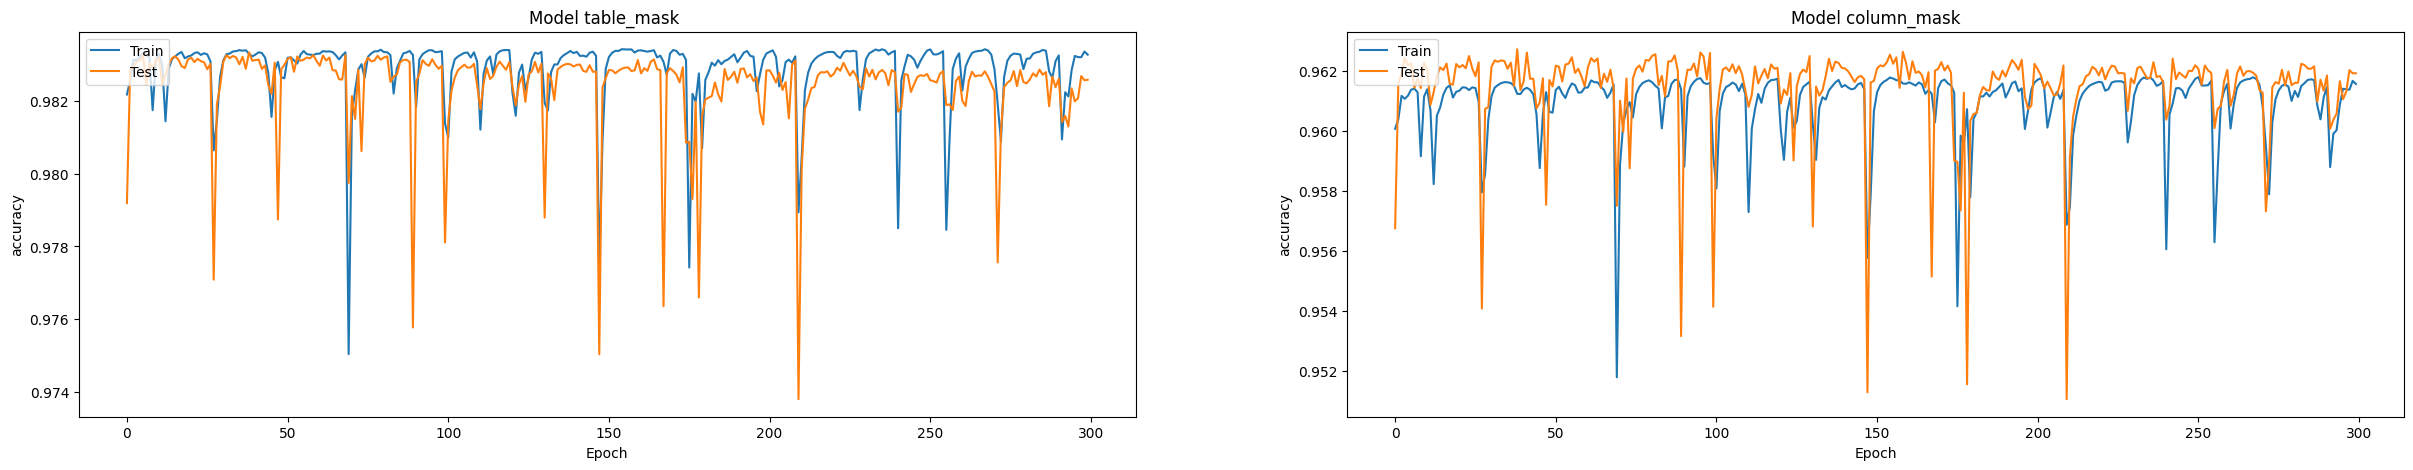

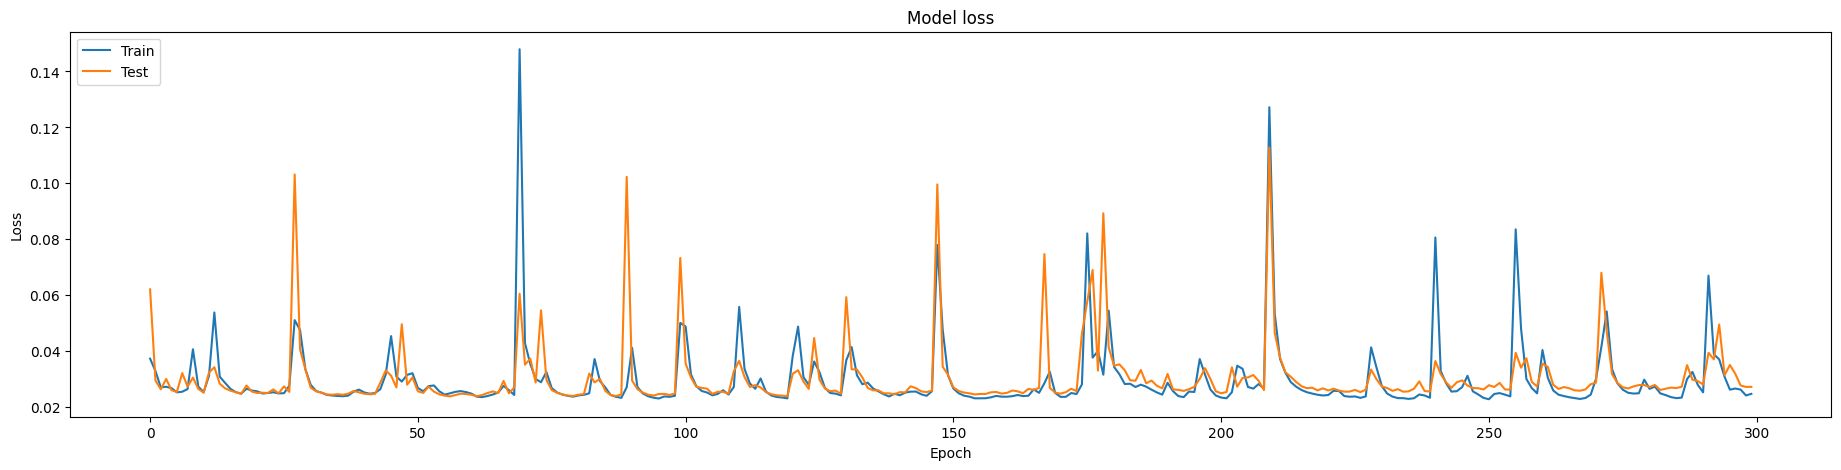

In [8]:
# Plot training & validation iou_score values
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(model_history.history['table_mask_accuracy'])
plt.plot(model_history.history['val_table_mask_accuracy'])
plt.title('Model table_mask ')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(model_history.history['column_mask_accuracy'])
plt.plot(model_history.history['val_column_mask_accuracy'])
plt.title('Model column_mask')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(50, 5))
plt.subplot(122)
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

def masks(table_mask, column_mask):
  table_mask = tf.argmax(table_mask, axis=-1)
  table_mask = table_mask[..., tf.newaxis]


  column_mask = tf.argmax(column_mask, axis=-1)
  column_mask = column_mask[..., tf.newaxis]
  return table_mask[0], column_mask[0]
